In [87]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from scipy import stats
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.patheffects as path_effects
import warnings
warnings.filterwarnings('ignore')


In [88]:
df=pd.read_csv('Education-services-with-station-access_loc.csv', low_memory=False)

pd.set_option('display.max_columns',None) 
pd.set_option('display.max_rows',None) 
pd.set_option('display.max_info_columns', 200) 

In [ ]:
# 1.service type
service_type = [
    'Long Day Care',
    'Preschool/Kindergarten - Part of a School',
    'Preschool/Kindergarten - Stand alone',
    'Outside school Hours Care - After School',
    'Outside school Hours Care - Before School',
    'Outside school Hours Care - Vacation Care',
    'Other'
]

for col in service_type:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.upper()
        df[col] = df[col].replace({
            'YES': 'Yes', 
            'NO': 'No', 
            'TRUE': 'Yes', 
            'FALSE': 'No', 
            '1': 'Yes', 
            '0': 'No'
        })
        df[col] = df[col].fillna('No')

service_names_short = [
    'LDC - Long Day Care',
    'PSK - Part of School',
    'PSK - Stand alone',
    'OSHC - After School',
    'OSHC - Before School',
    'OSHC - Vacation Care']
name_map = dict(zip(service_type, service_names_short))



# 2.minimum transport distance
df['MinTransportDistance'] = df[['DistanceToTrainStation_km', 
                                   'DistanceToBusStation_km']].min(axis=1)




# 3.rating score

rating_map = {
    'Excellent': 5,
    'Exceeding NQS': 4,
    'Meeting NQS': 3,
    'Working Towards NQS': 2,
    'Significant Improvement Required': 1
}
df['RatingScore'] = df['OverallRating'].map(rating_map)

rating_order = ['Excellent',
                'Exceeding NQS',
                'Meeting NQS',
                'Working Towards NQS',
                'Significant Improvement Required']



# 4.operating hours

days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# calculation
def hours_between(start, end):
    if pd.isna(start) or pd.isna(end):
        return np.nan
    s = pd.to_datetime(start, errors='coerce')
    e = pd.to_datetime(end,   errors='coerce')
    if pd.isna(s) or pd.isna(e):
        return np.nan
    hrs = (e - s).total_seconds() / 3600.0
    if hrs < 0:
        hrs += 12   # 跨夜补 12 小时
    if hrs < 0 or hrs > 24:
        return np.nan
    return hrs

# na
def safe_get(row, colname):
    return row[colname] if colname in row and pd.notna(row[colname]) else np.nan

# calculate the length of annual, SchoolTerm (session1+session2), and holiday
# takes the maximum value
for d in days:
    a_start = f'Annual {d} Start Time'
    a_end   = f'Annual {d} End Time'

    s1_start = f'School Terms Only Session 1 {d} Start Time'
    s1_end   = f'School Terms Only Session 1 {d} End Time'
    s1_start_alt = f'School Terms Only Session1 {d} Start Time'
    s1_end_alt   = f'School Terms Only Session1 {d} End Time'

    s2_start = f'School Terms Only Session 2 {d} Start Time'
    s2_end   = f'School Terms Only Session 2 {d} End Time'
    s2_start_alt = f'School Terms Only Session2 {d} Start Time'
    s2_end_alt   = f'School Terms Only Session2 {d} End Time'

    h_start = f'Holiday Care {d} Start Time'
    h_end   = f'Holiday Care {d} End Time'

    def per_row_day_hours(row):

        a_hrs = hours_between(safe_get(row, a_start), safe_get(row, a_end))

 
        s1_s = safe_get(row, s1_start)
        s1_e = safe_get(row, s1_end)
        if pd.isna(s1_s) and pd.isna(s1_e):
            s1_s = safe_get(row, s1_start_alt)
            s1_e = safe_get(row, s1_end_alt)
        s1_hrs = hours_between(s1_s, s1_e)


        s2_s = safe_get(row, s2_start)
        s2_e = safe_get(row, s2_end)
        if pd.isna(s2_s) and pd.isna(s2_e):
            s2_s = safe_get(row, s2_start_alt)
            s2_e = safe_get(row, s2_end_alt)
        s2_hrs = hours_between(s2_s, s2_e)


        st_hrs = np.nansum([s1_hrs, s2_hrs]) if (pd.notna(s1_hrs) or pd.notna(s2_hrs)) else np.nan

 
        h_hrs = hours_between(safe_get(row, h_start), safe_get(row, h_end))

        candidates = [a_hrs, st_hrs, h_hrs]
        if all(pd.isna(x) for x in candidates):
            return np.nan
        return np.nanmax(candidates)


    df[f'AnnualHours_{d}'] = df.apply(per_row_day_hours, axis=1)


daily_cols = [f'AnnualHours_{d}' for d in days]

df['AllDaysNA'] = df[daily_cols].isna().all(axis=1)


df['OpenDays'] = df[daily_cols].gt(0).sum(axis=1)
df.loc[df['AllDaysNA'], 'OpenDays'] = np.nan

# average on open day
df['DailyAvgHours_open'] = np.where(
    df['OpenDays'] > 0,
    df[daily_cols].sum(axis=1, skipna=True) / df['OpenDays'],
    np.nan
)

plot_series = df.loc[
    df['DailyAvgHours_open'].between(1, 16, inclusive='both'),
    'DailyAvgHours_open'
].dropna()

# 5.postcode to sos
aus = gpd.read_file('/Users/shuuwaka/Desktop/qbus6860/SOS_2021_AUST_GDA94_SHP')
aus = aus.dropna()
aus.geometry = aus.geometry.simplify(0.001)
aus['SOS_CODE21'] = aus['SOS_CODE21'].astype(str)

postcode_df = pd.read_csv('postcode_to_sos.csv')
services_df = pd.read_csv('Education-services-with-station-access_loc.csv')

postcode_df['SOS_Code'] = postcode_df['SOS_Code'].astype(str)
services_df['Postcode_int'] = pd.to_numeric(services_df['Postcode'], errors='coerce').astype('Int64')
postcode_df['Postcode_int'] = pd.to_numeric(postcode_df['Postcode'], errors='coerce').astype('Int64')

result = services_df.merge(postcode_df[['Postcode_int', 'Urban_Rural', 'SOS_Code', 'SOS_Name']], 
                           on='Postcode_int', how='left')
result['DistanceToTrainStation_km'] = pd.to_numeric(result['DistanceToTrainStation_km'], errors='coerce')
result['DistanceToBusStation_km'] = pd.to_numeric(result['DistanceToBusStation_km'], errors='coerce')
result['MinDistance'] = result[['DistanceToTrainStation_km', 'DistanceToBusStation_km']].min(axis=1)



In [ ]:
df.head() 

In [ ]:
df.info()

In [ ]:
df.describe(include='all') 

In [ ]:
df.isnull().sum()

In [ ]:
df['OverallRating'].value_counts()

In [ ]:
rating_order = ['Excellent','Exceeding NQS', 'Meeting NQS', 'Working Towards NQS', 'Significant Improvement Required']

plt.figure(figsize=(10,5))

df_melted = df.melt(
    value_vars=['PreviousOverallRating', 'OverallRating' ],
    var_name='OverallRating',
    value_name='Rating'
)

ax = sns.countplot( data=df_melted, x='Rating', hue='OverallRating', order = rating_order,  palette=['#3C6C8B','#DD8452'], width=0.4 )

for i in ax.containers:
    ax.bar_label(i, fontsize=10, padding=2)

plt.xlabel('Previous Overall Rating', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Previous Overall Rating Count', fontsize=15, fontweight='bold', pad=20)
plt.legend(labels=['Previous', 'Current'])

plt.xticks(fontsize=8)
plt.show()

In [ ]:
state_list = sorted(df['State'].dropna().astype(str).unique())[:24]

color_current = '#3C6C8B'   
color_previous = '#DD8452'  


fig, axes = plt.subplots(2, 4, figsize=(20, 14))
axes = axes.flatten()

for i, state in enumerate(state_list):
    ax = axes[i]
    df_state = df[df['State'] == state]

    if df_state.empty:
        ax.axis('off')
        continue

    df_melted = df_state.melt(
        value_vars=['PreviousOverallRating', 'OverallRating'],
        var_name='Period',
        value_name='Rating'
    )

    sns.countplot(data=df_melted, x='Rating', hue='Period', order=rating_order, palette=[color_previous, color_current], width=0.6, ax=ax)

    ax.set_title(f'{state}', fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=25)
    ax.legend([], [], frameon=False)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Overall Rating Distribution (Current vs Previous) by State', fontsize=18, fontweight='bold', y=0.97)
plt.tight_layout(rect=[0, 0, 1, 0.94])

fig.legend(['Previous', 'Current'], loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)

plt.show()
plt.savefig('Overall Rating Distribution (Current vs Previous) by State.png', dpi=300, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(12,7))

rating_colors = ['Excellent',
               'Exceeding NQS',
               'Meeting NQS',
               'Working Towards NQS',
               'Significant Improvement Required']


color_dict = {'Excellent':'#4F7C77',
                      'Exceeding NQS':'#3C6C8B',
                      'Meeting NQS':'#D9A441',
                      'Working Towards NQS':'#C1665A',
                      'Significant Improvement Required':'#5A4A49'}
color_dict_previous = {k: sns.desaturate(v, 0.4) for k, v in color_dict.items()}


state_order = (df['State'].value_counts().index)
    
ax = sns.countplot(data=df, x='State', hue='OverallRating', hue_order = rating_colors, palette=color_dict, width=0.7)

for i in ax.containers:
    ax.bar_label(i, fontsize=6, padding=2)

plt.xlabel('State', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Overall Rating by State', fontsize=15, fontweight='bold', pad=20)

plt.legend(loc='upper right', fontsize=10, framealpha=0.9) 


plt.show()
plt.savefig('Overall Rating by State.png', dpi=300, bbox_inches='tight')

In [ ]:
color_current = '#3C6C8B'
color_previous = '#DD8452'
rating_order = ['Excellent','Exceeding NQS','Meeting NQS','Working Towards NQS','Significant Improvement Required']

df_long = df.melt(
    id_vars=['OverallRating', 'PreviousOverallRating'],
    value_vars=service_type,
    var_name='ServiceType',
    value_name='HasService'
)
df_long = df_long[df_long['HasService'] == 'Yes']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, svc in enumerate(service_type[:len(axes)]):
    ax = axes[i]
    df_svc = df_long[df_long['ServiceType'] == svc]

    if df_svc.empty:
        ax.axis('off')
        continue

    df_melted = df_svc.melt(
        value_vars=['PreviousOverallRating', 'OverallRating'],
        var_name='Period',
        value_name='Rating')

    sns.countplot(data=df_melted, x='Rating', hue='Period', order=rating_order, palette=[color_previous, color_current], width=0.6, ax=ax)

    ax.set_title(name_map.get(svc, svc), fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=25)
    ax.legend([], [], frameon=False)


fig.suptitle('Overall Rating Distribution (Current vs Previous) by Service Type',
             fontsize=18, fontweight='bold', y=0.97)
plt.tight_layout(rect=[0, 0, 1, 0.94])

fig.legend(['Previous', 'Current'], loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)

plt.show()
plt.savefig('Overall Rating Distribution (Current vs Previous) by Service Type', dpi=300, bbox_inches='tight')

In [ ]:
states = sorted(df['State'].dropna().unique())

fig, ax = plt.subplots(figsize=(8, 5))

high_quality_pct = []
low_quality_pct = []

for state in states:
    state_data = df[df['State'] == state]
    total = len(state_data[state_data['OverallRating'].notna()])
    
    if total > 0:
        high = len(state_data[state_data['OverallRating'].isin(['Exceeding NQS', 'Excellent'])])
        low = len(state_data[state_data['OverallRating'].isin(
            ['Working Towards NQS', 'Significant Improvement Required'])])
        
        high_quality_pct.append((high / total) * 100)
        low_quality_pct.append((low / total) * 100)
    else:
        high_quality_pct.append(0)
        low_quality_pct.append(0)

x = np.arange(len(states))
width = 0.35

bars1 = ax.barh(x, high_quality_pct, width, 
                 label='High Quality (Exceeding/Excellent)',
                 color='#DD8452', alpha=0.8)
bars2 = ax.barh(x, [-p for p in low_quality_pct], width,
                 label='Low Quality (Working Towards/Sig. Impr.)',
                 color='#3C6C8B', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels([])
for i, state in enumerate(states):
    ax.text(0, i, f'  {state}  ', ha='center', va='center', 
            fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.1', facecolor='white', 
                     edgecolor='black', linewidth=1, alpha=0.9))
    
ax.set_xlabel('Percentage (%)', fontweight='bold')
ax.set_title('Quality Distribution by State\n(High vs Low Quality)',
              fontweight='bold', fontsize=12)
ax.axvline(x=0, color='black', linewidth=1)
ax.legend(loc='upper right', fontsize=8)
ax.grid(axis='x', alpha=0.3, linestyle='--')

for i, (h, l) in enumerate(zip(high_quality_pct, low_quality_pct)):
    ax.text(h + 1, i, f'{h:.1f}%', va='center', fontsize=8, fontweight='bold')
    ax.text(-l - 1, i, f'{l:.1f}%', va='center', ha='right', 
             fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig('Quality Distribution by State\n(High vs Low Quality.png', dpi=300, bbox_inches='tight')

In [ ]:
for col in service_type:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.upper()
        df[col] = df[col].replace({'YES': 'Yes', 'NO': 'No', 'TRUE': 'Yes', 'FALSE': 'No', '1': 'Yes', '0': 'No'})
        df[col] = df[col].fillna('No')

fig, ax = plt.subplots(figsize=(8, 5))
high_quality_pct = []
low_quality_pct = []

for service_col, service_name in zip(service_type, service_names_short):
    service_data = df[df[service_col] == 'Yes']
    total = len(service_data[service_data['OverallRating'].notna()])
    
    if total > 0:
        high = len(service_data[service_data['OverallRating'].isin(['Exceeding NQS', 'Excellent'])])
        low = len(service_data[service_data['OverallRating'].isin(
            ['Working Towards NQS', 'Significant Improvement Required'])])
        
        high_quality_pct.append((high / total) * 100)
        low_quality_pct.append((low / total) * 100)
    else:
        high_quality_pct.append(0)
        low_quality_pct.append(0)

x = np.arange(len(service_names_short))
width = 0.35

bars1 = ax.barh(x, high_quality_pct, width, 
                 label='High Quality (Exceeding/Excellent)',
                 color='#DD8452', alpha=0.8)
bars2 = ax.barh(x, [-p for p in low_quality_pct], width,
                 label='Low Quality (Working Towards/Sig. Impr.)',
                 color='#3C6C8B', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels([])

for i, service_name in enumerate(service_names_short):
    ax.text(0, i, f'  {service_name}  ', ha='center', va='center', 
            fontsize=8, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.1', facecolor='white', 
                     edgecolor='black', linewidth=1, alpha=0.9))
    
ax.set_xlabel('Percentage (%)', fontweight='bold')
ax.set_title('Quality Distribution by Service Type\n(High vs Low Quality)',
              fontweight='bold', fontsize=12)
ax.axvline(x=0, color='black', linewidth=1)
ax.legend(loc='upper right', fontsize=8)
ax.grid(axis='x', alpha=0.3, linestyle='--')

for i, (h, l) in enumerate(zip(high_quality_pct, low_quality_pct)):
    ax.text(h + 1, i, f'{h:.1f}%', va='center', fontsize=8, fontweight='bold')
    ax.text(-l - 1, i, f'{l:.1f}%', va='center', ha='right', 
             fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig('service_type_quality_exact_style.png', dpi=300, bbox_inches='tight')

In [ ]:
df_valid = df.dropna(subset=['DistanceToBusStation_km', 'DistanceToTrainStation_km', 'OverallRating'])
df_plot = df_valid[df_valid['OverallRating'].isin(color_dict.keys())].copy()

plt.figure(figsize=(6, 6))

for rating, color in color_dict.items():
    data = df_plot[df_plot['OverallRating'] == rating]
    plt.scatter(data['DistanceToBusStation_km'], data['DistanceToTrainStation_km'],c=color, label=rating, s=10, alpha=0.6, linewidth=0.3)

plt.xlabel('Distance to Train Station (km)', fontsize=8, fontweight='bold')
plt.ylabel('Distance to Bus Station (km)', fontsize=8, fontweight='bold')
plt.title('Childcare Services: Train Station vs Bus Station Distance by Rating', 
          fontsize=9, fontweight='bold', pad=20)


plt.legend(loc='upper right', fontsize=6, framealpha=0.9)

plt.show()
plt.savefig('Childcare Services: Train Station vs Bus Station Distance by Rating.png', dpi=300, bbox_inches='tight')

In [ ]:
df['DistanceToTrainStation_km'].describe()

In [ ]:
df['DistanceToBusStation_km'].describe()

In [ ]:
s = pd.to_numeric(df['MinTransportDistance'], errors='coerce')
s = s.dropna()
s = s[s.between(0, 200)] 

p95 = s.quantile(0.95)
p99 = s.quantile(0.99)

print(f'(95%: {p95:.2f} km, 99%: {p99:.2f} km)')


In [ ]:
df_filtered = df[df['MinTransportDistance'] <= 50].copy()

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_filtered,
    x='MinTransportDistance', y='RatingScore',
    color='#3C6C8B', s=25, alpha=0.6
)

plt.xlabel('Minimum Distance to Public Transport (km)', fontsize=12, fontweight='bold')
plt.ylabel('Quality Rating Score (1–5)', fontsize=12, fontweight='bold')
plt.title('Service Rating vs Transport Accessibility', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()
plt.savefig('Service Rating vs Transport Accessibility.png', dpi=300, bbox_inches='tight')

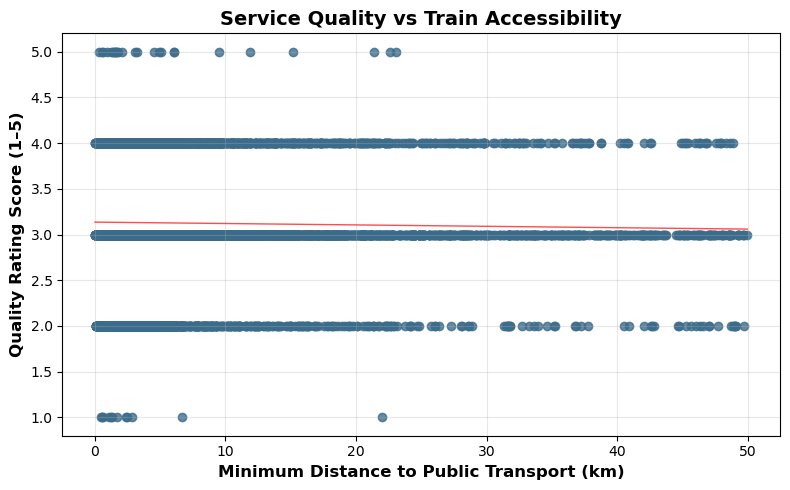

In [48]:
plt.figure(figsize=(8,5))
sns.regplot(
    x='MinTransportDistance', 
    y='RatingScore', 
    data=df_filtered,
    ci=False, 
    color='#3C6C8B', 
    line_kws={'color':'r', 'alpha':0.7, 'lw':1}
)

plt.xlabel('Minimum Distance to Public Transport (km)', fontsize=12, fontweight='bold')
plt.ylabel('Quality Rating Score (1–5)', fontsize=12, fontweight='bold')
plt.title('Service Quality vs Train Accessibility Reg', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()
plt.savefig('Service Rating vs Transport Accessibility Reg.png', dpi=300, bbox_inches='tight')

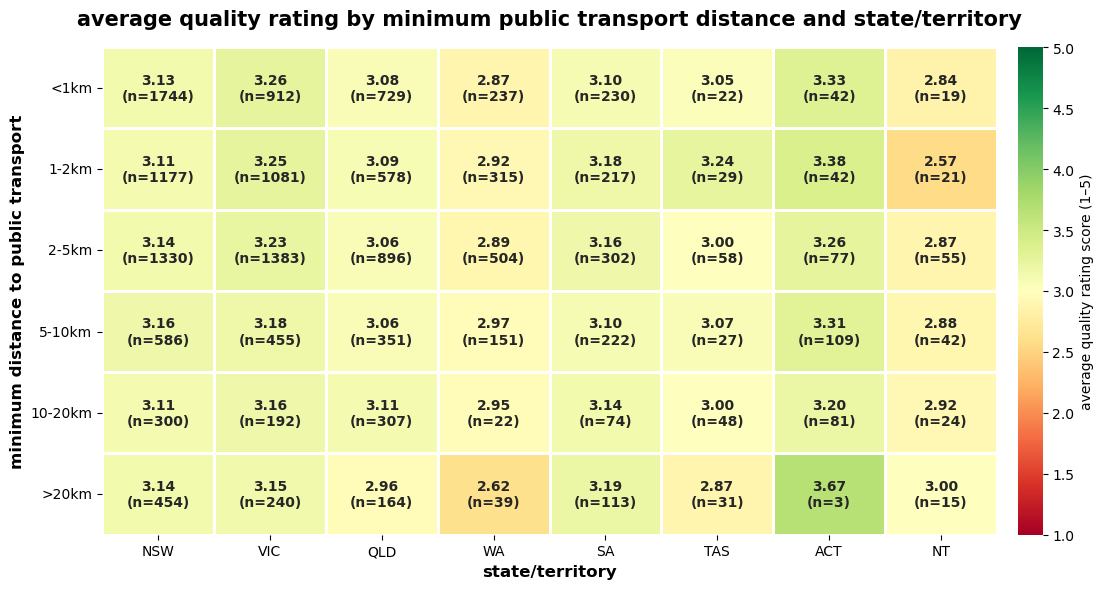

In [73]:
state_candidates = ['State', 'State/Territory', 'State or Territory', 'STATE', 'Jurisdiction']
state_col = next((c for c in state_candidates if c in df.columns), None)


df['MinTransportDistanceGroup'] = pd.cut(
    pd.to_numeric(df['MinTransportDistance'], errors='coerce'),
    bins=[0, 1, 2, 5, 10, 20, 100],
    labels=['<1km', '1-2km', '2-5km', '5-10km', '10-20km', '>20km']
)


tmp = df[[state_col, 'MinTransportDistanceGroup', 'RatingScore']].copy()
tmp['_STATE_'] = tmp[state_col].astype(str).str.upper().str.strip()


pivot_rating = tmp.pivot_table(
    values='RatingScore',
    index='MinTransportDistanceGroup',
    columns='_STATE_',
    aggfunc='mean'
)
pivot_count = tmp.pivot_table(
    values='RatingScore',
    index='MinTransportDistanceGroup',
    columns='_STATE_',
    aggfunc='count'
)


distance_order = ['<1km', '1-2km', '2-5km', '5-10km', '10-20km', '>20km']
state_order = ['NSW', 'VIC', 'QLD', 'WA', 'SA', 'TAS', 'ACT', 'NT']
existing_states = [s for s in state_order if s in pivot_rating.columns]

pivot_rating = pivot_rating.reindex(index=distance_order, columns=existing_states)
pivot_count  = pivot_count.reindex(index=distance_order, columns=existing_states)

ann = []
for i in range(len(pivot_rating.index)):
    row = []
    for j in range(len(pivot_rating.columns)):
        r = pivot_rating.iloc[i, j]
        n = pivot_count.iloc[i, j]
        row.append(f'{r:.2f}\n(n={int(n)})' if pd.notna(r) and pd.notna(n) else '')
    ann.append(row)

# 7) 作图
plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_rating,
    annot=ann, fmt='',
    cmap='RdYlGn', vmin=1, vmax=5, center=3,
    linewidths=2, linecolor='white',
    cbar_kws={'label': 'average quality rating score (1–5)', 'pad': 0.02},
    annot_kws={'size': 10, 'weight': 'bold'}
)

plt.title('Average Quality Rating by Minimum Public Transport Distance and State/Territory', fontsize=15, pad=16, fontweight='bold')
plt.xlabel('state/territory', fontsize=12, fontweight='bold')
plt.ylabel('minimum distance to public transport', fontsize=12, fontweight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()
plt.savefig('Average Quality Rating by Minimum Public Transport Distance and State/Territory.png', dpi=300, bbox_inches='tight')



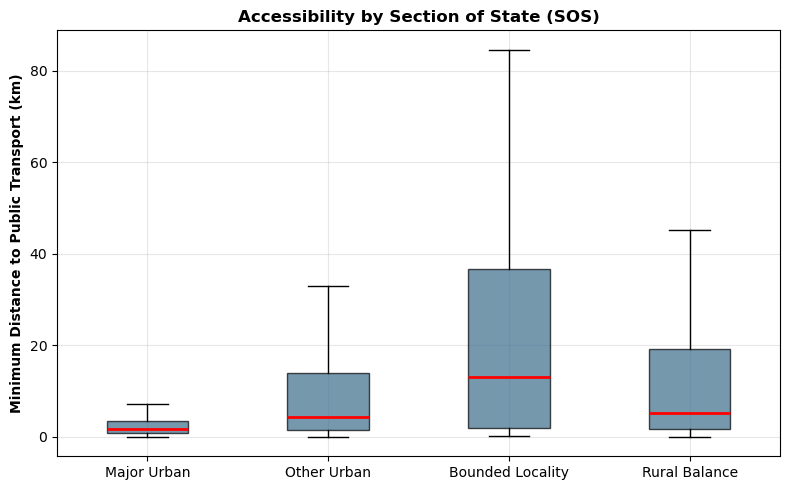

In [74]:
sos_order = ['Major Urban', 'Other Urban', 'Bounded Locality', 'Rural Balance']
# ensure the order actually exists in your data (in case some categories missing)
sos_order = [cat for cat in sos_order if cat in result['SOS_Name'].unique()]
df_plot = result[result['SOS_Name'].isin(sos_order)].copy()
plt.figure(figsize=(8,5))
data_to_plot = [df_plot.loc[df_plot['SOS_Name']==cat, 'MinDistance'].dropna() for cat in sos_order]
plt.boxplot(
    data_to_plot,
    labels=sos_order,
    showfliers=False,
    patch_artist=True,
    boxprops=dict(facecolor='#3C6C8B', alpha=0.7, edgecolor='black'),
    medianprops=dict(color='red', linewidth=2)
)
plt.ylabel('Minimum Distance to Public Transport (km)', fontweight='bold')
plt.title('Accessibility by Section of State (SOS)', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()
plt.savefig('Accessibility by Section of State (SOS).png', dpi=300, bbox_inches='tight')


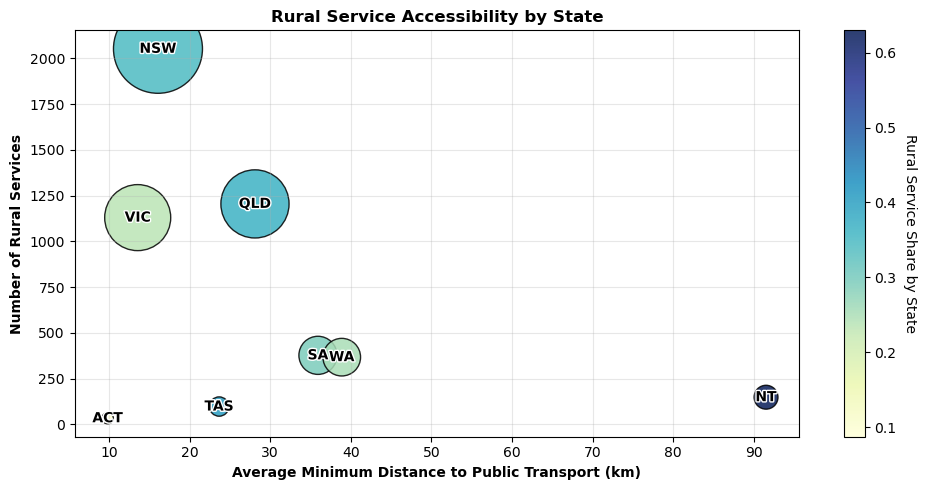

In [75]:
rural_classes = ['Rural', 'Rural Balance', 'Bounded Locality'] 
state_total = result.groupby('State', dropna=False)['MinDistance'].size().rename('TotalCount')
state_rural = result[result['Urban_Rural'].isin(rural_classes)].groupby('State')['MinDistance'].size().rename('RuralCount')

rural_share_df = pd.concat([state_total, state_rural], axis=1).fillna(0)
rural_share_df['rural_share'] = rural_share_df['RuralCount'] / rural_share_df['TotalCount']

rural_df = result[result['Urban_Rural'].isin(rural_classes)].copy()
bubble = (rural_df.groupby('State')['MinDistance']
          .agg(['mean','size'])
          .reset_index()
          .rename(columns={'mean':'AvgDistance_km','size':'ServiceCount'}))

bubble = bubble.merge(rural_share_df[['rural_share']], left_on='State', right_index=True, how='left')

plt.figure(figsize=(10,5))
sc = plt.scatter(
    bubble['AvgDistance_km'],
    bubble['ServiceCount'],
    s=bubble['ServiceCount'] * 2,
    c=bubble['rural_share'],
    cmap='YlGnBu',
    edgecolors='black',
    alpha=0.85)


for _, row in bubble.iterrows():
    txt = plt.text(
        row['AvgDistance_km'], row['ServiceCount'], row['State'],
        ha='center', va='center', color='black', weight='bold', fontsize=10)
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='white'),
        path_effects.Normal()])

cbar = plt.colorbar(sc)
cbar.set_label('Rural Service Share by State', rotation=270, labelpad=15)
plt.xlabel('Average Minimum Distance to Public Transport (km)', fontweight='bold')
plt.ylabel('Number of Rural Services', fontweight='bold')
plt.title('Rural Service Accessibility by State', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()
plt.savefig('Rural Service Accessibility by State.png', dpi=300, bbox_inches='tight')

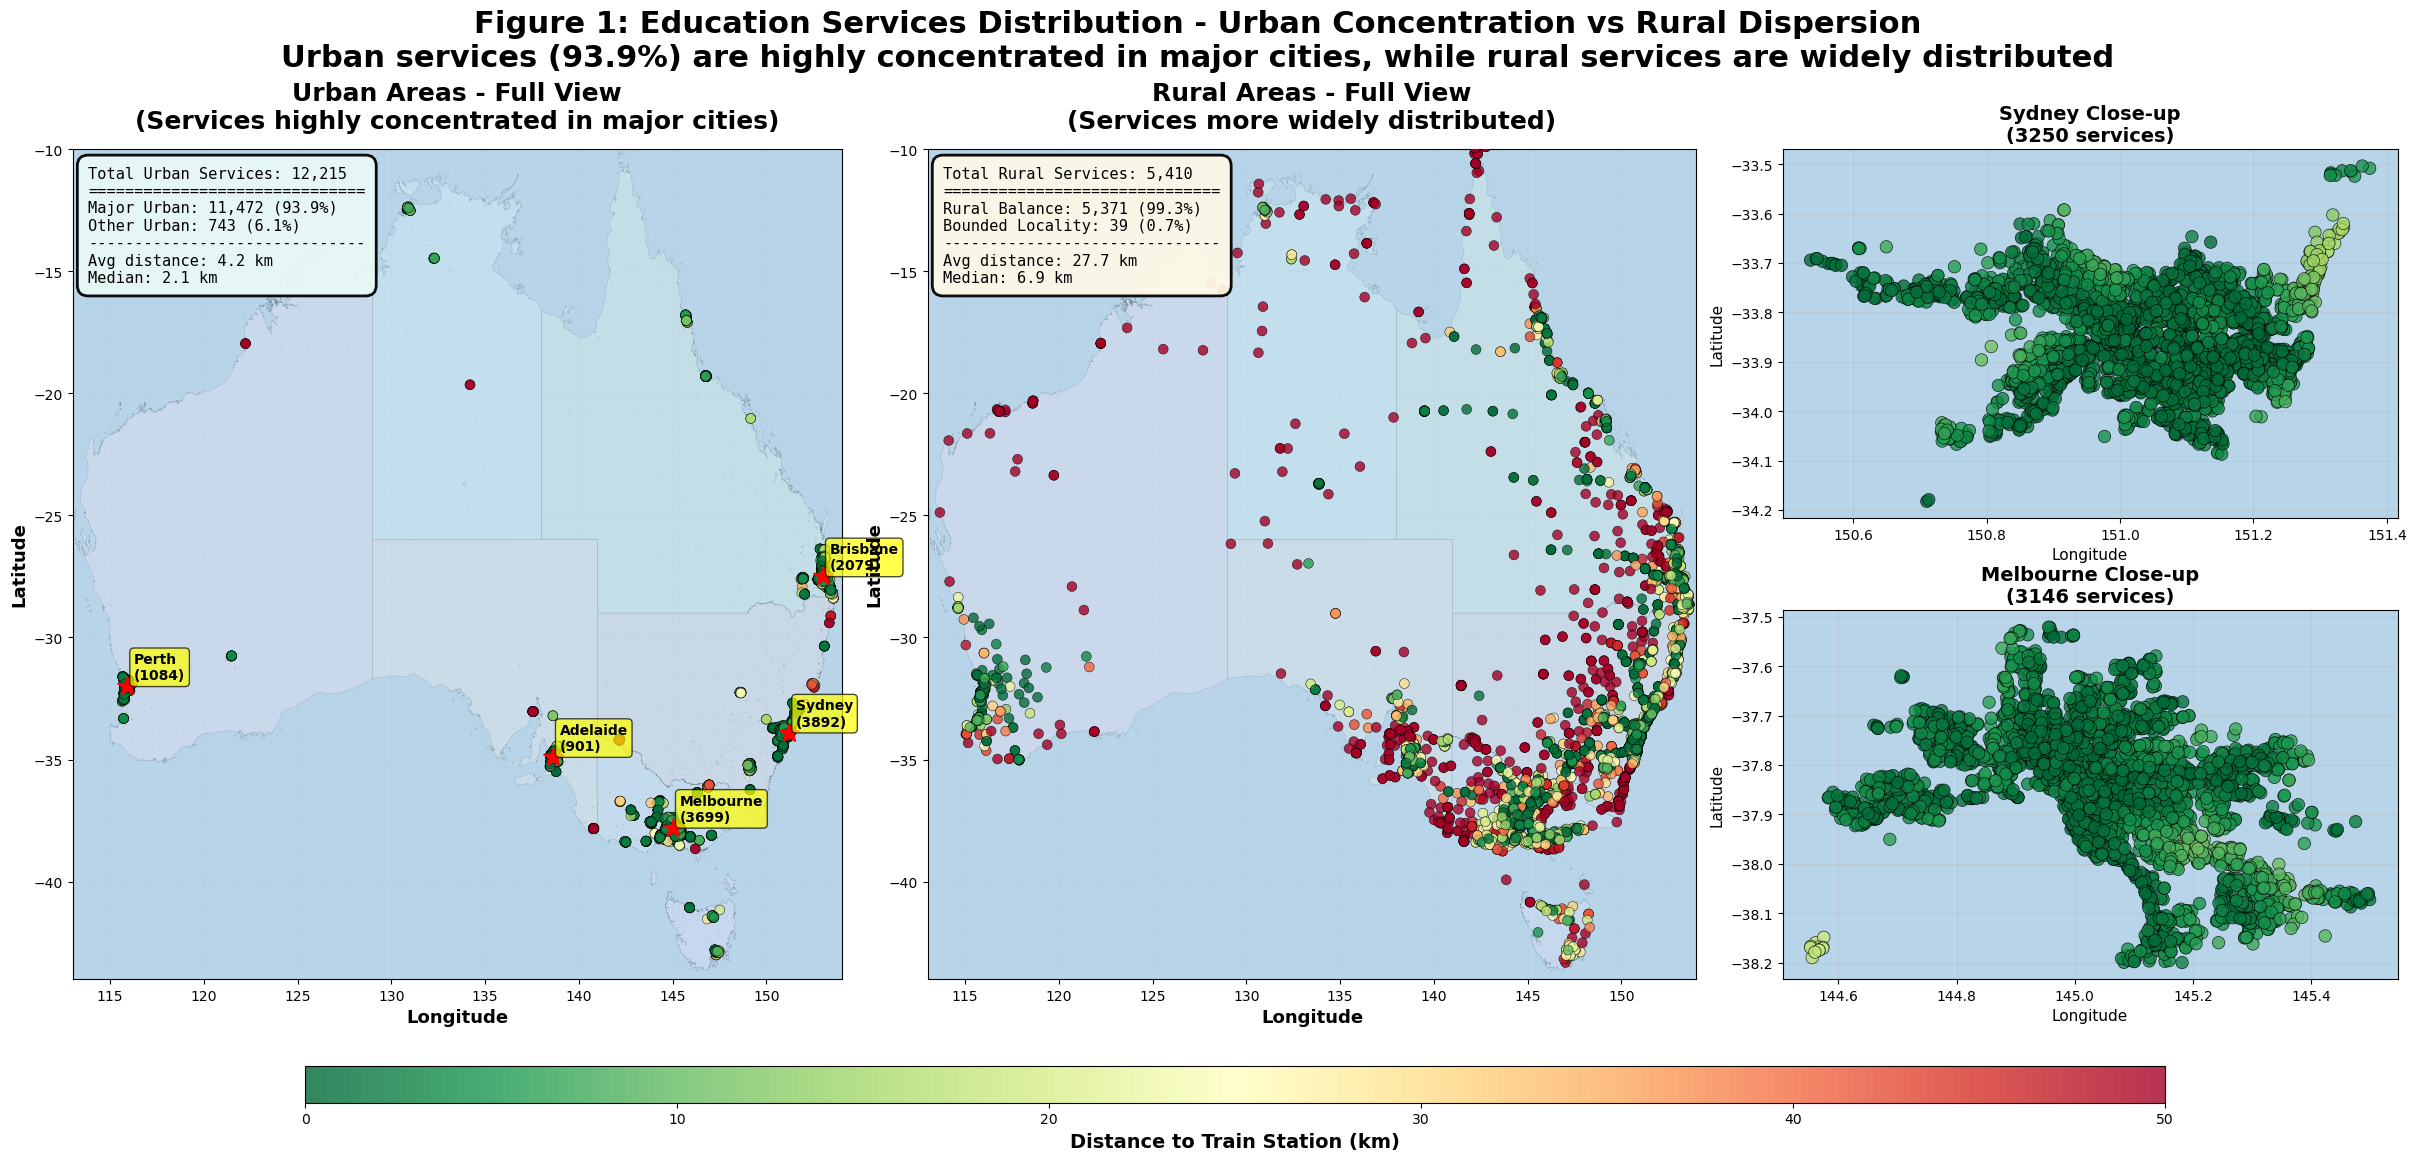

In [56]:
def extract_coords(geom_str):
    try:
        coords = str(geom_str).strip('c()').split(',')
        return float(coords[0]), float(coords[1])
    except:
        return None, None

result[['longitude', 'latitude']] = result['geometry'].apply(
    lambda x: pd.Series(extract_coords(x)) if pd.notna(x) else pd.Series([None, None])
)

df = result[(result['Urban_Rural'].isin(['Urban', 'Rural'])) & 
            (result['longitude'].notna()) & 
            (result['latitude'].notna())].copy()

# Create figure
fig = plt.figure(figsize=(30, 14))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.8], hspace=0.25, wspace=0.12)

# State colors
state_colors = {
    '1': '#FFE6E6', '2': '#E6F2FF', '3': '#E6FFE6', '4': '#FFF4E6',
    '5': '#FFE6F2', '6': '#F2E6FF', '7': '#E6FFFF', '8': '#FFFFF0',
}

# Left: Urban full view
ax1 = fig.add_subplot(gs[:, 0])
ax1.set_facecolor('#B8D4E8')

for _, sos_row in aus.iterrows():
    if sos_row.geometry is not None:
        sos_code = str(sos_row.get('SOS_CODE21', ''))
        state_prefix = sos_code[0] if len(sos_code) > 0 else '0'
        color = state_colors.get(state_prefix, '#f0f0f0')
        
        if isinstance(sos_row.geometry, Polygon):
            xs, ys = sos_row.geometry.exterior.xy
            ax1.fill(xs, ys, facecolor=color, edgecolor='#34495E',
                    linewidth=0.3, alpha=0.25, zorder=1)
        elif isinstance(sos_row.geometry, MultiPolygon):
            for polygon in sos_row.geometry.geoms:
                xs, ys = polygon.exterior.xy
                ax1.fill(xs, ys, facecolor=color, edgecolor='#34495E',
                        linewidth=0.3, alpha=0.25, zorder=1)

urban_df = df[df['Urban_Rural'] == 'Urban']
scatter1 = ax1.scatter(urban_df['longitude'], urban_df['latitude'],
                      c=urban_df['DistanceToTrainStation_km'],
                      cmap='RdYlGn_r', s=50, alpha=0.8,
                      edgecolors='black', linewidth=0.4,
                      vmin=0, vmax=50, zorder=3)

ax1.set_title('Urban Areas - Full View\n(Services highly concentrated in major cities)', 
             fontsize=18, fontweight='bold', pad=15)
ax1.set_xlabel('Longitude', fontsize=13, fontweight='bold')
ax1.set_ylabel('Latitude', fontsize=13, fontweight='bold')
ax1.set_xlim(113, 154)
ax1.set_ylim(-44, -10)
ax1.grid(True, alpha=0.2, linestyle=':')

cities = {
    'Sydney': (151.2, -33.9, 3892),
    'Melbourne': (145.0, -37.8, 3699),
    'Brisbane': (153.0, -27.5, 2079),
    'Perth': (115.9, -32.0, 1084),
    'Adelaide': (138.6, -34.9, 901)
}

for city, (lon, lat, count) in cities.items():
    ax1.plot(lon, lat, 'r*', markersize=15, zorder=4)
    ax1.annotate(f'{city}\n({count})', xy=(lon, lat), xytext=(5, 5),
                textcoords='offset points', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                zorder=5)

stats1 = f'Total Urban Services: {len(urban_df):,}\n'
stats1 += f'{'='*30}\n'
stats1 += f'Major Urban: {(urban_df['SOS_Name']=='Major Urban').sum():,} (93.9%)\n'
stats1 += f'Other Urban: {(urban_df['SOS_Name']=='Other Urban').sum():,} (6.1%)\n'
stats1 += f'{'-'*30}\n'
stats1 += f'Avg distance: {urban_df['DistanceToTrainStation_km'].mean():.1f} km\n'
stats1 += f'Median: {urban_df['DistanceToTrainStation_km'].median():.1f} km'

ax1.text(0.02, 0.98, stats1, transform=ax1.transAxes,
        fontsize=11, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round,pad=0.7', facecolor='#E8F8F5',
                 alpha=0.95, edgecolor='black', linewidth=2))

# Middle: Rural full view
ax2 = fig.add_subplot(gs[:, 1])
ax2.set_facecolor('#B8D4E8')

for _, sos_row in aus.iterrows():
    if sos_row.geometry is not None:
        sos_code = str(sos_row.get('SOS_CODE21', ''))
        state_prefix = sos_code[0] if len(sos_code) > 0 else '0'
        color = state_colors.get(state_prefix, '#f0f0f0')
        
        if isinstance(sos_row.geometry, Polygon):
            xs, ys = sos_row.geometry.exterior.xy
            ax2.fill(xs, ys, facecolor=color, edgecolor='#34495E',
                    linewidth=0.3, alpha=0.25, zorder=1)
        elif isinstance(sos_row.geometry, MultiPolygon):
            for polygon in sos_row.geometry.geoms:
                xs, ys = polygon.exterior.xy
                ax2.fill(xs, ys, facecolor=color, edgecolor='#34495E',
                        linewidth=0.3, alpha=0.25, zorder=1)

rural_df = df[df['Urban_Rural'] == 'Rural']
scatter2 = ax2.scatter(rural_df['longitude'], rural_df['latitude'],
                      c=rural_df['DistanceToTrainStation_km'],
                      cmap='RdYlGn_r', s=50, alpha=0.8,
                      edgecolors='black', linewidth=0.4,
                      vmin=0, vmax=50, zorder=3)

ax2.set_title('Rural Areas - Full View\n(Services more widely distributed)', 
             fontsize=18, fontweight='bold', pad=15)
ax2.set_xlabel('Longitude', fontsize=13, fontweight='bold')
ax2.set_ylabel('Latitude', fontsize=13, fontweight='bold')
ax2.set_xlim(113, 154)
ax2.set_ylim(-44, -10)
ax2.grid(True, alpha=0.2, linestyle=':')

stats2 = f'Total Rural Services: {len(rural_df):,}\n'
stats2 += f'{'='*30}\n'
stats2 += f'Rural Balance: {(rural_df['SOS_Name']=='Rural Balance').sum():,} (99.3%)\n'
stats2 += f'Bounded Locality: {(rural_df['SOS_Name']=='Bounded Locality').sum():,} (0.7%)\n'
stats2 += f'{'-'*30}\n'
stats2 += f'Avg distance: {rural_df['DistanceToTrainStation_km'].mean():.1f} km\n'
stats2 += f'Median: {rural_df['DistanceToTrainStation_km'].median():.1f} km'

ax2.text(0.02, 0.98, stats2, transform=ax2.transAxes,
        fontsize=11, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round,pad=0.7', facecolor='#FEF9E7',
                 alpha=0.95, edgecolor='black', linewidth=2))

# Right top: Sydney close-up
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_facecolor('#B8D4E8')

sydney_urban = urban_df[(urban_df['longitude'] > 150.5) & 
                        (urban_df['longitude'] < 151.5) &
                        (urban_df['latitude'] > -34.2) & 
                        (urban_df['latitude'] < -33.5)]

scatter3 = ax3.scatter(sydney_urban['longitude'], sydney_urban['latitude'],
                      c=sydney_urban['DistanceToTrainStation_km'],
                      cmap='RdYlGn_r', s=80, alpha=0.8,
                      edgecolors='black', linewidth=0.5,
                      vmin=0, vmax=50, zorder=3)

ax3.set_title(f'Sydney Close-up\n({len(sydney_urban)} services)', 
             fontsize=14, fontweight='bold')
ax3.set_xlabel('Longitude', fontsize=11)
ax3.set_ylabel('Latitude', fontsize=11)
ax3.grid(True, alpha=0.3)

# Right bottom: Melbourne close-up
ax4 = fig.add_subplot(gs[1, 2])
ax4.set_facecolor('#B8D4E8')

melbourne_urban = urban_df[(urban_df['longitude'] > 144.5) & 
                           (urban_df['longitude'] < 145.5) &
                           (urban_df['latitude'] > -38.2) & 
                           (urban_df['latitude'] < -37.5)]

scatter4 = ax4.scatter(melbourne_urban['longitude'], melbourne_urban['latitude'],
                      c=melbourne_urban['DistanceToTrainStation_km'],
                      cmap='RdYlGn_r', s=80, alpha=0.8,
                      edgecolors='black', linewidth=0.5,
                      vmin=0, vmax=50, zorder=3)

ax4.set_title(f'Melbourne Close-up\n({len(melbourne_urban)} services)', 
             fontsize=14, fontweight='bold')
ax4.set_xlabel('Longitude', fontsize=11)
ax4.set_ylabel('Latitude', fontsize=11)
ax4.grid(True, alpha=0.3)

# title and colorbar
fig.suptitle('Education Services Distribution - Urban Concentration vs Rural Dispersion\n' +
            'Urban services (93.9%) are highly concentrated in major cities, while rural services are widely distributed',
            fontsize=22, fontweight='bold', y=0.98)

cbar = fig.colorbar(scatter2, ax=[ax1, ax2, ax3, ax4], 
                   location='bottom', pad=0.08, aspect=50, shrink=0.8)
cbar.set_label('Distance to Train Station (km)', fontsize=14, fontweight='bold')

plt.show()
plt.savefig('Education Services Distribution.png', dpi=300, bbox_inches='tight', facecolor='white')


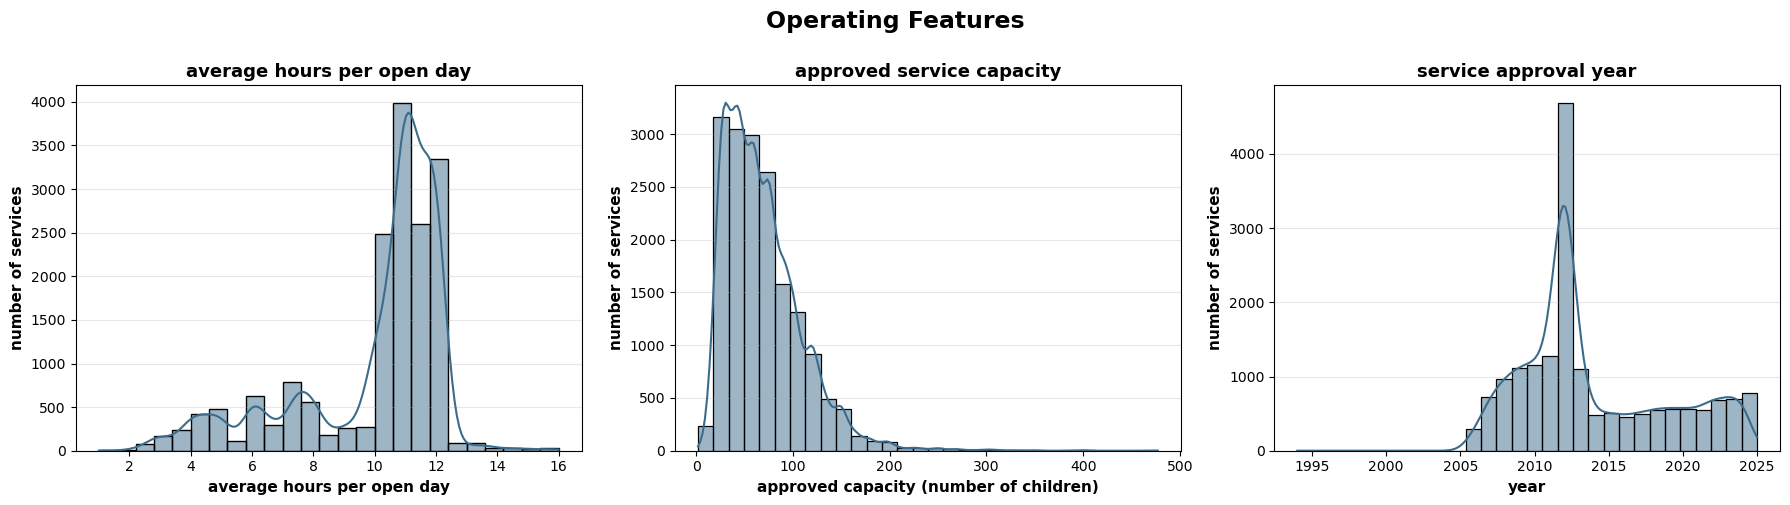

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))


# left: operating hours
sns.histplot(plot_series, bins=25, kde=True, color='#3C6C8B', ax=ax1)
ax1.set_title('average hours per open day', fontsize=13, fontweight='bold')
ax1.set_xlabel('average hours per open day', fontsize=11, fontweight='bold')
ax1.set_ylabel('number of services', fontsize=11, fontweight='bold')
ax1.grid(alpha=0.3, axis='y')

# middle: capacity
sns.histplot(df['NumberOfApprovedPlaces'].dropna(), bins=30, kde=True, 
             color='#3C6C8B', ax=ax2)
ax2.set_title('approved service capacity', fontsize=13, fontweight='bold')
ax2.set_xlabel('approved capacity (number of children)', fontsize=11, fontweight='bold')
ax2.set_ylabel('number of services', fontsize=11, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# right: approval year
df['ServiceApprovalGrantedDate'] = pd.to_datetime(df['ServiceApprovalGrantedDate'], 
                                                   format='%d/%m/%Y', errors='coerce')
df['ApprovalYear'] = df['ServiceApprovalGrantedDate'].dt.year

sns.histplot(df['ApprovalYear'].dropna(), bins=30, kde=True, 
             color='#3C6C8B', ax=ax3)
ax3.set_title('service approval year', fontsize=13, fontweight='bold')
ax3.set_xlabel('year', fontsize=11, fontweight='bold')
ax3.set_ylabel('number of services', fontsize=11, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

fig.suptitle('Approved Service Characteristics',
            fontsize=17, fontweight='bold', y=1)
plt.tight_layout()

plt.show()
plt.savefig('Approved Service Characteristics.png', dpi=300, bbox_inches='tight', facecolor='white')

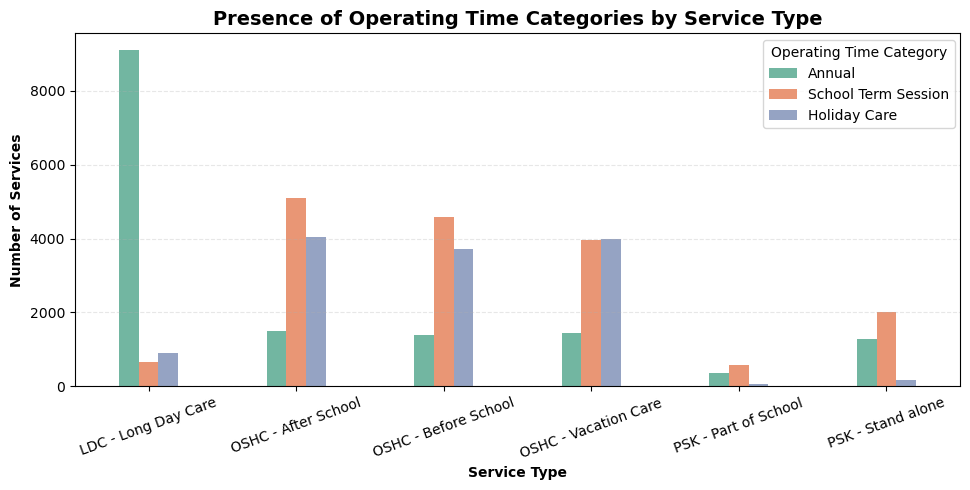

<Figure size 640x480 with 0 Axes>

In [86]:
annual_cols = [col for col in df.columns if col.startswith('Annual ')]
session_cols = [col for col in df.columns if col.startswith('School Terms Only Session')]
holiday_cols = [col for col in df.columns if col.startswith('Holiday Care')]

df['Has_Annual']  = df[annual_cols].notna().any(axis=1)
df['Has_Session'] = df[session_cols].notna().any(axis=1)
df['Has_Holiday'] = df[holiday_cols].notna().any(axis=1)



df_long = df.melt(
    id_vars=['Has_Annual','Has_Session','Has_Holiday'],
    value_vars=service_type,
    var_name='ServiceType',
    value_name='HasService'
)
df_long = df_long[df_long['HasService'].str.lower() == 'yes']
df_long['ServiceType'] = df_long['ServiceType'].map(name_map)

summary = df_long.groupby('ServiceType')[['Has_Annual','Has_Session','Has_Holiday']].sum().reset_index()

summary_melted = summary.melt(
    id_vars='ServiceType',
    var_name='TimeCategory',
    value_name='Count'
)

time_map = {
    'Has_Annual': 'Annual',
    'Has_Session': 'School Term Session',
    'Has_Holiday': 'Holiday Care'
}
summary_melted['TimeCategory'] = summary_melted['TimeCategory'].map(time_map)

plt.figure(figsize=(10,5))
sns.barplot(data=summary_melted, x='ServiceType', y='Count',
            hue='TimeCategory', palette='Set2', width=0.4)

plt.title('Presence of Operating Time Categories by Service Type', fontsize=14, fontweight='bold')
plt.xlabel('Service Type', fontsize=10, fontweight='bold')
plt.ylabel('Number of Services', fontsize=10, fontweight='bold')
plt.xticks(rotation=20)
plt.legend(title='Operating Time Category', bbox_to_anchor=(0.77,1), loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

plt.show()
plt.savefig('Presence of Operating Time Categories by Service Type.png', dpi=300, bbox_inches='tight', facecolor='white')

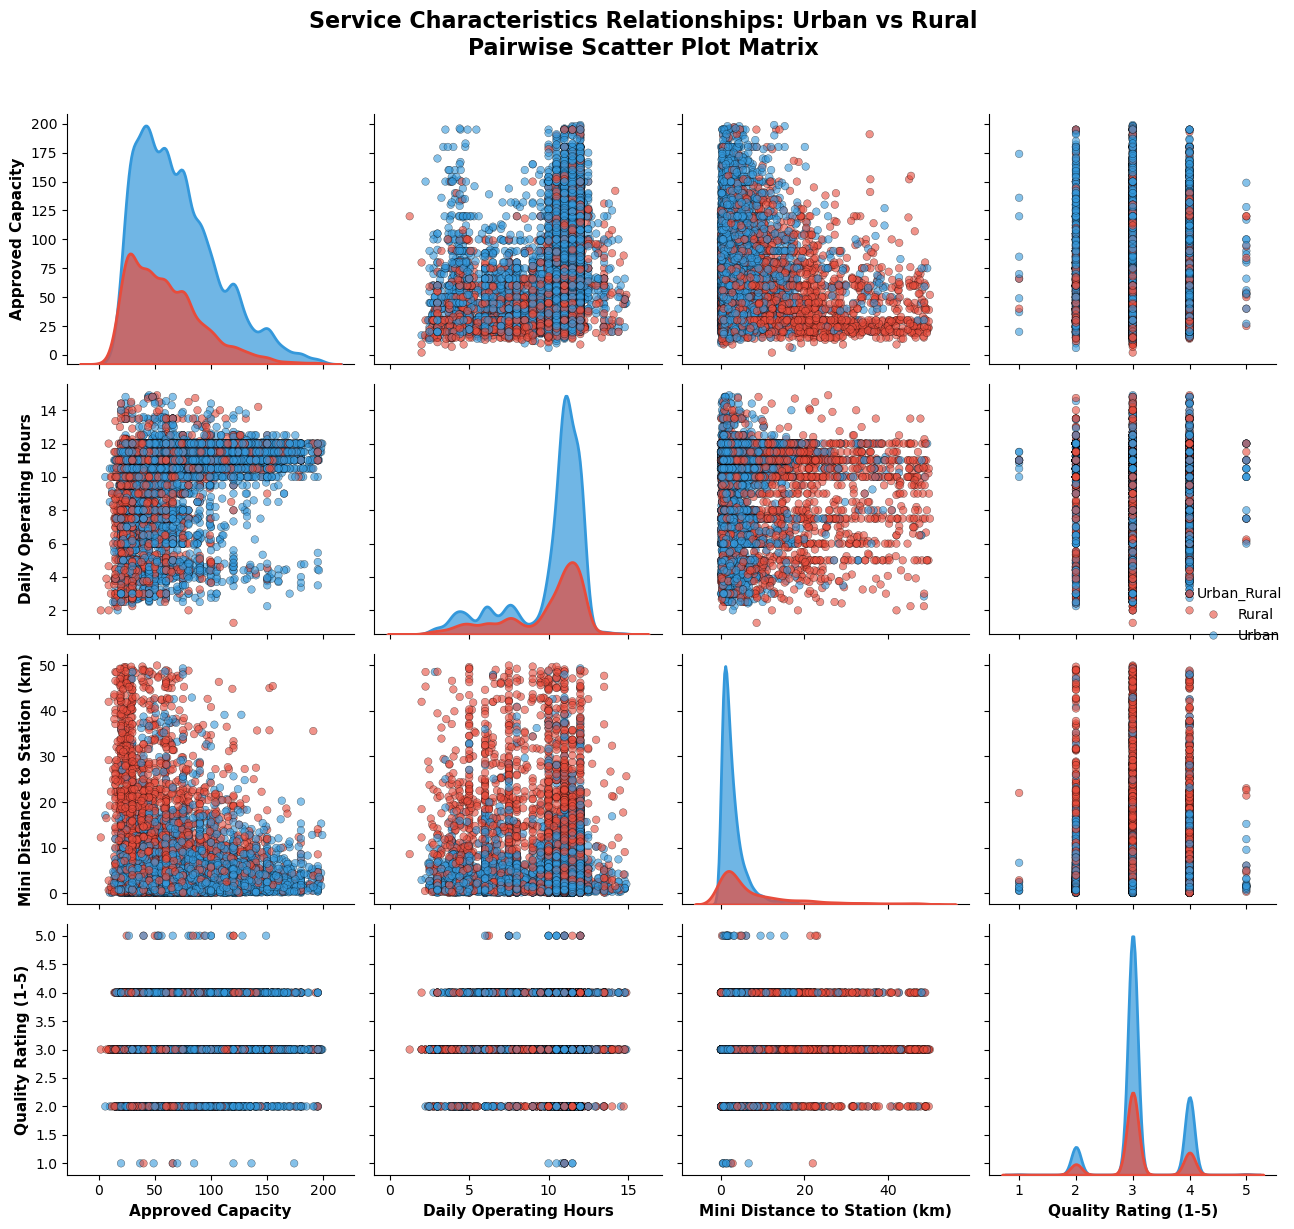

In [64]:
df['ApprovalYear'] = pd.to_datetime(df['ServiceApprovalGrantedDate'], 
                                     format='%d/%m/%Y', errors='coerce').dt.year

plot_vars = [
    'NumberOfApprovedPlaces',
    'DailyAvgHours_open', 
    'MinTransportDistance',
    'RatingScore'
]

#filtered
plot_data = df[plot_vars + ['Urban_Rural']].dropna()

plot_data = plot_data[
    (plot_data['NumberOfApprovedPlaces'] < 200) &
    (plot_data['DailyAvgHours_open'] < 15) &
    (plot_data['MinTransportDistance'] < 50)
]


g = sns.pairplot(
    plot_data, 
    hue='Urban_Rural',
    palette={'Urban': '#3498db', 'Rural': '#e74c3c'},
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'black', 'linewidth': 0.3},
    diag_kws={'alpha': 0.7, 'linewidth': 2},
    height=3,
    aspect=1
)

labels = [
    'Approved Capacity',
    'Daily Operating Hours',
    'Minimum Distance to Station (km)',
    'Quality Rating (1-5)'
]

for i in range(len(plot_vars)):
    for j in range(len(plot_vars)):
        ax = g.axes[i, j]
        if i == len(plot_vars) - 1:
            ax.set_xlabel(labels[j], fontsize=11, fontweight='bold')
        if j == 0:
            ax.set_ylabel(labels[i], fontsize=11, fontweight='bold')

g.fig.suptitle('Service Characteristics Relationships: Urban vs Rural\nPairwise Scatter Plot Matrix', 
              fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()

plt.show()
plt.savefig('pairplot_urban_rural.png', dpi=300, bbox_inches='tight', facecolor='white')

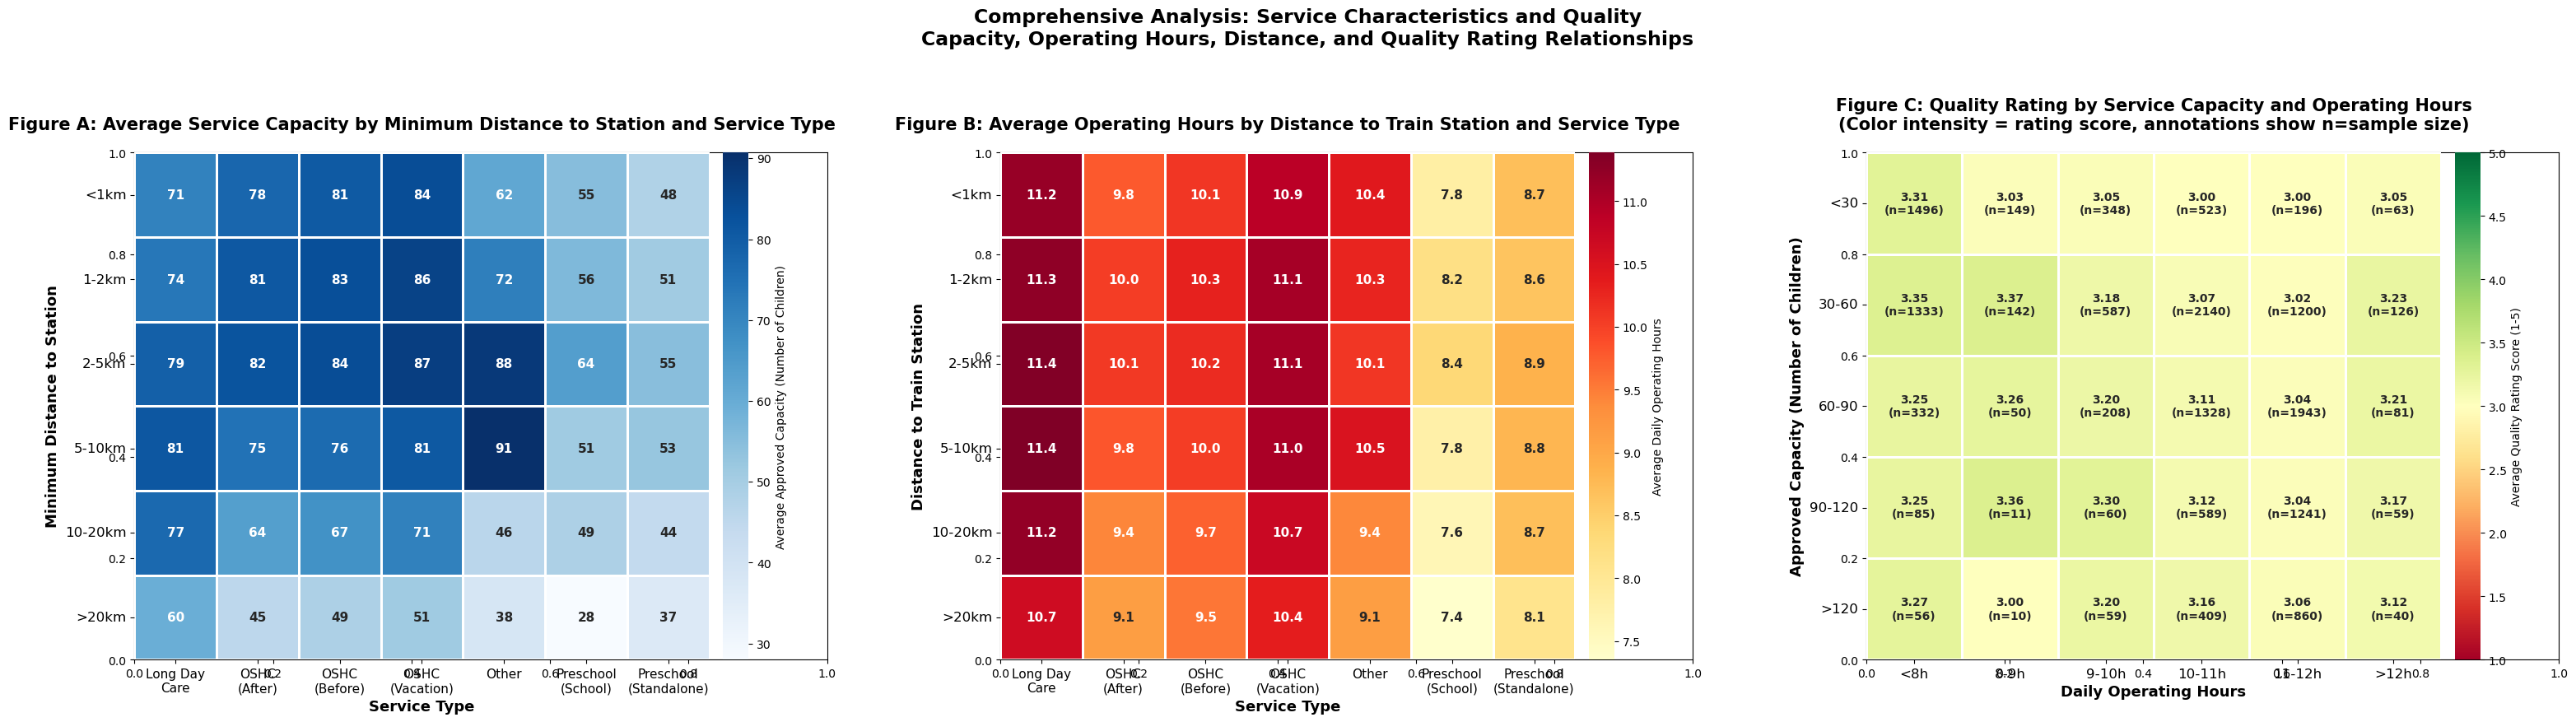

In [79]:
df['DistanceGroup'] = pd.cut(
    df['MinTransportDistance'],
    bins=[0, 1, 2, 5, 10, 20, 100],
    labels=['<1km', '1-2km', '2-5km', '5-10km', '10-20km', '>20km']
)

df['CapacityGroup'] = pd.cut(
    df['NumberOfApprovedPlaces'],
    bins=[0, 30, 60, 90, 120, 500],
    labels=['<30', '30-60', '60-90', '90-120', '>120']
)

df['HoursGroup'] = pd.cut(
    df['DailyAvgHours_open'],
    bins=[0, 8, 9, 10, 11, 12, 20],
    labels=['<8h', '8-9h', '9-10h', '10-11h', '11-12h', '>12h']
)



long_format_data = []

for _, row in df.iterrows():
    for service_col in service_type:
        if str(row.get(service_col, '')).strip().lower() == 'yes':
            if service_col == 'Long Day Care':
                service_name = 'Long Day\nCare'
            elif service_col == 'Preschool/Kindergarten - Part of a School':
                service_name = 'Preschool\n(School)'
            elif service_col == 'Preschool/Kindergarten - Stand alone':
                service_name = 'Preschool\n(Standalone)'
            elif service_col == 'Outside school Hours Care - After School':
                service_name = 'OSHC\n(After)'
            elif service_col == 'Outside school Hours Care - Before School':
                service_name = 'OSHC\n(Before)'
            elif service_col == 'Outside school Hours Care - Vacation Care':
                service_name = 'OSHC\n(Vacation)'
            else:
                service_name = service_col
            
            long_format_data.append({
                'DistanceGroup': row['DistanceGroup'],
                'ServiceType': service_name,
                'RatingScore': row['RatingScore'],
                'NumberOfApprovedPlaces': row['NumberOfApprovedPlaces'],
                'DailyAvgHours_open': row.get('DailyAvgHours_open', None)
            })

df_long = pd.DataFrame(long_format_data)
df_long = df_long[df_long['DistanceGroup'].notna()]


#pivot1
pivot_capacity = df_long.pivot_table(
    values='NumberOfApprovedPlaces', 
    index='DistanceGroup', 
    columns='ServiceType', 
    aggfunc='mean'
)

#pivot2
pivot_hours = df_long.pivot_table(
    values='DailyAvgHours_open',
    index='DistanceGroup',
    columns='ServiceType',
    aggfunc='mean'
)

#pivot3
df_filtered = df[
    df['CapacityGroup'].notna() & 
    df['HoursGroup'].notna() & 
    df['RatingScore'].notna()
].copy()

pivot_rating_matrix = df_filtered.pivot_table(
    values='RatingScore',
    index='CapacityGroup',
    columns='HoursGroup',
    aggfunc='mean'
)

pivot_count_matrix = df_filtered.pivot_table(
    values='RatingScore',
    index='CapacityGroup',
    columns='HoursGroup',
    aggfunc='count'
)



fig = plt.figure(figsize=(38, 8))  
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.25)  


ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])


ax1 = fig.add_subplot(gs[0])

distance_order = ['<1km', '1-2km', '2-5km', '5-10km', '10-20km', '>20km']

pivot_capacity = pivot_capacity.reindex(distance_order)
pivot_hours = pivot_hours.reindex(distance_order)

sns.heatmap(pivot_capacity, 
            annot=True, 
            fmt='.0f', 
            cmap='Blues',
            cbar_kws={'label': 'Average Approved Capacity (Number of Children)', 'pad': 0.02},
            linewidths=2,
            linecolor='white',
            ax=ax1,
            annot_kws={'size': 11, 'weight': 'bold'})

ax1.set_title('Figure A: Average Service Capacity by Minimum Distance to Station and Service Type', 
             fontsize=15, fontweight='bold', pad=20)
ax1.set_xlabel('Service Type', fontsize=13, fontweight='bold')
ax1.set_ylabel('Minimum Distance to Station', fontsize=13, fontweight='bold')
ax1.tick_params(axis='x', rotation=0, labelsize=11)
ax1.tick_params(axis='y', rotation=0, labelsize=12)

ax2 = fig.add_subplot(gs[1])

sns.heatmap(pivot_hours, 
            annot=True, 
            fmt='.1f', 
            cmap='YlOrRd',
            cbar_kws={'label': 'Average Daily Operating Hours', 'pad': 0.02},
            linewidths=2,
            linecolor='white',
            ax=ax2,
            annot_kws={'size': 11, 'weight': 'bold'})

ax2.set_title('Figure B: Average Operating Hours by Distance to Train Station and Service Type', 
             fontsize=15, fontweight='bold', pad=20)
ax2.set_xlabel('Service Type', fontsize=13, fontweight='bold')
ax2.set_ylabel('Distance to Train Station', fontsize=13, fontweight='bold')
ax2.tick_params(axis='x', rotation=0, labelsize=11)
ax2.tick_params(axis='y', rotation=0, labelsize=12)

ax3 = fig.add_subplot(gs[2])

annotations = []
for i in range(len(pivot_rating_matrix.index)):
    row_annots = []
    for j in range(len(pivot_rating_matrix.columns)):
        rating = pivot_rating_matrix.iloc[i, j]
        count = pivot_count_matrix.iloc[i, j]
        
        if pd.notna(rating) and pd.notna(count):
            annot_text = f'{rating:.2f}\n(n={int(count)})'
        else:
            annot_text = ''
        row_annots.append(annot_text)
    annotations.append(row_annots)

capacity_order = ['<30', '30-60', '60-90', '90-120', '>120']
hours_order = ['<8h', '8-9h', '9-10h', '10-11h', '11-12h', '>12h']

pivot_rating_matrix = pivot_rating_matrix.reindex(index=capacity_order, columns=hours_order)
pivot_count_matrix = pivot_count_matrix.reindex(index=capacity_order, columns=hours_order)

sns.heatmap(pivot_rating_matrix, 
            annot=annotations,
            fmt='',
            cmap='RdYlGn',
            center=3.0,
            vmin=1,
            vmax=5,
            cbar_kws={'label': 'Average Quality Rating Score (1-5)', 'pad': 0.02},
            linewidths=2,
            linecolor='white',
            ax=ax3,
            annot_kws={'size': 10, 'weight': 'bold'})

ax3.set_title('Figure C: Quality Rating by Service Capacity and Operating Hours\n(Color intensity = rating score, annotations show n=sample size)', 
             fontsize=15, fontweight='bold', pad=20)
ax3.set_xlabel('Daily Operating Hours', fontsize=13, fontweight='bold')
ax3.set_ylabel('Approved Capacity (Number of Children)', fontsize=13, fontweight='bold')
ax3.tick_params(axis='x', rotation=0, labelsize=12)
ax3.tick_params(axis='y', rotation=0, labelsize=12)


fig.suptitle('Comprehensive Analysis: Service Characteristics and Quality\nCapacity, Operating Hours, Distance, and Quality Rating Relationships',
            fontsize=17, fontweight='bold', y=1.1)


plt.show()
plt.savefig('three_panel_heatmap_analysis.png', dpi=300, bbox_inches='tight')
